In [246]:
import requests 
import urllib
import urllib3
import time
import pandas as pd
import re
import csv
import numpy as np
import copy
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from bs4 import BeautifulSoup
from lxml.html.soupparser import fromstring
from uuid import uuid4 as uuid
from lxml import html
from datetime import datetime

%matplotlib inline

# Scraping and, Importing, and Cleaning

In [2]:
def scrape_and_bake(url):
    testframe = pd.DataFrame(columns=['author', 'subreddit', 'timestamp',
                   'rank', 'comments', 'score', 'crossposts', 'full_name', 'title', 'elapsed'])    
    for i in range(1,1001):
        
        pattern = re.compile('thing id')
        html = requests.get(url ,headers={"User-agent": str(uuid())})
        soup = BeautifulSoup(html.text, 'lxml')

        for post in soup.find_all('div', {'class' : pattern}):
            try:
                author = post['data-author']
            except:
                None
            try:
                subreddit = post['data-subreddit']
            except:
                None
            try:
                ID = post['id']
            except:
                None
            try:
                timestamp = post['data-timestamp']
            except:
                None
            try:
                rank = post['data-rank']
            except:
                None
            try:
                comments = post['data-comments-count']
            except:
                None
            try:
                score = post['data-score']
            except:
                None
            try:
                crossposts = post['data-num-crossposts']
            except:
                None
            try:
                full_name = post['data-fullname']
            except:
                None
                
            try:
                title = post.find('a', {'data-event-action': 'title'}).text
            except:
                None
            try:
                elapsed = post.find('time', {'class': 'live-timestamp'}).text
            except:
                None


            testframe.loc[len(testframe)] = [author, subreddit, timestamp,
                   rank, comments, score, crossposts, full_name, title, elapsed]

            result = testframe.loc[max(testframe.index), 'full_name']
            url = "http://www.reddit.com/?count={}&after={}".format(25*i, result)
            
            scrapeddata = [author, subreddit, timestamp,
                   rank, comments, score, crossposts, full_name, title, elapsed]
            
#             print(len(scrapeddata))
            scrapeframe = pd.DataFrame(np.array(scrapeddata).reshape(1,10), columns=['author', 'subreddit', 'timestamp',
                   'rank', 'comments', 'score', 'crossposts', 'full_name', 'title', 'elapsed'])
#             scrapeframe = scrapeframe.transpose
            
            with open('scraped.csv', 'a') as f:
                scrapeframe.to_csv(f, header=False)

In [89]:
scrape_and_bake('https://www.reddit.com/')

# WARNING! This is my scrape actionable. DO NOT RUN THIS unless you want to scrape and have ~15 minutes of free time
# This cell has been locked into read-only to prevent accidental runs.

In [247]:
data = pd.read_csv('/Users/skiparay/Desktop/GA/Projects/project-3/scraped.csv', names= ['author', 'subreddit', 'timestamp',
                   'rank', 'comments', 'score', 'crossposts', 'full_name', 'title', 'elapsed'])
data.reset_index(drop=True);

In [248]:
data['post_date'] = pd.to_datetime(data['timestamp'], origin='unix', unit='ms')

In [249]:
data['post_time_hours'] = (data['post_date'].apply(lambda x: x.hour))

In [250]:
data['post_time_hours'] = (data['post_time_hours'].astype(int))

In [251]:
data['post_time_hours'] = data['post_time_hours'].astype(str)
data['post_time_hours'] = data['post_time_hours'] + '00'

#Turning the hours column into strings so I can add the :00 to the end (just to make things look nicer).

In [252]:
data['post_time_hours'] = data['post_time_hours'].astype(int)
#And back into integers for modeling

In [253]:
data['post_day_of_week'] = data['post_date'].dt.weekday_name

In [254]:
data.head()

,author,subreddit,timestamp,rank,comments,score,crossposts,full_name,title,elapsed,post_date,post_time_hours,post_day_of_week
0,ffrosteh,news,1509478344000,1,5419,15315,0,t3_79y7k6,NYPD responding to reports of shots fired in l...,2 hours ago,2017-10-31 19:32:24,1900,Tuesday
0,paochow,funny,1509473643000,2,811,77648,0,t3_79xneh,So my friend went to the DMV on Halloween...,3 hours ago,2017-10-31 18:14:03,1800,Tuesday
0,onesincepearlharbor,wholesomememes,1509473604000,3,62,8202,0,t3_79xn7y,Day at the park,3 hours ago,2017-10-31 18:13:24,1800,Tuesday
0,clee3092,pics,1509470200000,4,678,21656,0,t3_79x8ol,My wife as Moana for the kiddies,4 hours ago,2017-10-31 17:16:40,1700,Tuesday
0,namraka,AnimalsBeingJerks,1509470528000,5,563,12019,0,t3_79xa88,Police dog steals the ball,4 hours ago,2017-10-31 17:22:08,1700,Tuesday


In [255]:
import datetime
import os

def creation_date(filename):
    t = os.path.getmtime(filename)
    t2 = datetime.datetime.fromtimestamp(t)
    return t2.strftime("%a %b %d %Y %H:%M:%S")

#This should give the creation date/time (i.e. the scraptime) of the CSV. file Code snippet adapted from here: 
#https://stackoverflow.com/questions/237079/how-to-get-file-creation-modification-date-times-in-python

In [256]:
creation_date('/Users/skiparay/Desktop/GA/Projects/project-3/scraped.csv')

'Fri Nov 03 2017 02:04:24'

In [257]:
data = data[['author', 'title', 'full_name', 'subreddit', 'comments', 'score', 'timestamp', 'post_date', 'post_time_hours', 'post_day_of_week', 'rank', 'crossposts', 'elapsed']]
data = data.rename(columns={'full_name':'unique_id', 'timestamp':'unix_timestamp', 'elapsed':'time_since_posting'})

In [258]:
data.nunique() 

author                 7326
title                  8166
unique_id              8368
subreddit              1635
comments               2948
score                 25505
unix_timestamp         8179
post_date              8179
post_time_hours          24
post_day_of_week          5
rank                  25000
crossposts                6
time_since_posting       84
dtype: int64

In [259]:
data.isnull().sum()

#Not expecting any null values, but just to be sure.

author                0
title                 0
unique_id             0
subreddit             0
comments              0
score                 0
unix_timestamp        0
post_date             0
post_time_hours       0
post_day_of_week      0
rank                  0
crossposts            0
time_since_posting    0
dtype: int64

In [260]:
data['post_date'].min()

Timestamp('2017-10-30 22:48:36')

In [261]:
data['post_date'].max()

Timestamp('2017-11-03 05:16:14')

In [262]:
dataunique = data.drop_duplicates(subset=['unique_id'])
dataunique.reset_index(drop=True);

#Dropping duplicates

In [18]:
def eda(dataframe):
    """

    :param dataframe: Data to run data analysis on
    :type dataframe: pandas DataFrame
    :return: None
    :rtype: None
    """
    assert type(dataframe) in [pd.DataFrame, pd.Series], "Expected pandas.DataFrame, {} is type {}".format(dataframe, type(dataframe))
    
    print("Dataframe Index:\n{}\n".format(dataframe.index))
    print("Dataframe Shape:\n{}\n".format(dataframe.shape))   
    for item in dataframe:
        print("---" * 39)
        print("Feature: {}".format(item))
        print("Data Type: {}\n".format(dataframe[item].dtypes))
        print("Unique Values: {}\n".format(dataframe[item].nunique()))
        print("Missing Values: {}".format(dataframe[item].isnull().sum()))
        print("\n{}".format(dataframe[item].describe(include='all')))
        
        # plotting
        if dataframe[item].nunique() == 1:  # skip plotting for columns with only one value
            print("\n{} is homogeneous".format(item))
            continue
            
        if dataframe[item].nunique() == dataframe[item].count():  # skip plotting when all values are unique
            print("\nIndex eligible - All values of {} are unique\n".format(item))
            continue
        
        if dataframe[item].dtype in [np.int64, np.float64]:
            sns.distplot(dataframe[item])
        elif dataframe[item].dtype in [np.object, dt.datetime]:
            sns.countplot(dataframe[item])
        plt.show()
        



In [70]:
eda(dataunique)

Dataframe Index:
RangeIndex(start=0, stop=6043, step=1)

Dataframe Shape:
(6043, 19)

---------------------------------------------------------------------------------------------------------------------
Feature: author
Data Type: object

Unique Values: 5410

Missing Values: 0

count            6043
unique           5410
top       1Voice1Life
freq               20
Name: author, dtype: object


AttributeError: 'DecisionTreeClassifier' object has no attribute 'datetime'

In [263]:
dataunique.head()

,author,title,unique_id,subreddit,comments,score,unix_timestamp,post_date,post_time_hours,post_day_of_week,rank,crossposts,time_since_posting
0,ffrosteh,NYPD responding to reports of shots fired in l...,t3_79y7k6,news,5419,15315,1509478344000,2017-10-31 19:32:24,1900,Tuesday,1,0,2 hours ago
0,paochow,So my friend went to the DMV on Halloween...,t3_79xneh,funny,811,77648,1509473643000,2017-10-31 18:14:03,1800,Tuesday,2,0,3 hours ago
0,onesincepearlharbor,Day at the park,t3_79xn7y,wholesomememes,62,8202,1509473604000,2017-10-31 18:13:24,1800,Tuesday,3,0,3 hours ago
0,clee3092,My wife as Moana for the kiddies,t3_79x8ol,pics,678,21656,1509470200000,2017-10-31 17:16:40,1700,Tuesday,4,0,4 hours ago
0,namraka,Police dog steals the ball,t3_79xa88,AnimalsBeingJerks,563,12019,1509470528000,2017-10-31 17:22:08,1700,Tuesday,5,0,4 hours ago


In [264]:
keys = [0.25, 0.5, 0.75, 0.95]
values = (dataunique['comments'].quantile([0.25, 0.5, 0.75, 0.95]))
commentpercdict = {round(key,4):round(value,4) for (key, value) in zip(values.index, values)}
commentpercdict

{0.25: 5.0, 0.5: 15.0, 0.75: 43.0, 0.94999999999999996: 260.64999999999998}

In [265]:
dataunique['Comments_25th_percentile'] = dataunique['comments'].apply(lambda x: 1 if x >= commentpercdict[0.250] else 0)
dataunique['Comments_Median'] = dataunique['comments'].apply(lambda x: 1 if x >= commentpercdict[0.500] else 0)
dataunique['Comments_75th_percentile'] = dataunique['comments'].apply(lambda x: 1 if x >= commentpercdict[0.750] else 0)
dataunique['Comments_95th_percentile'] = dataunique['comments'].apply(lambda x: 1 if x >= commentpercdict[0.950] else 0)

/Users/skiparay/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/skiparay/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/skiparay/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [266]:
keys = [0.25, 0.5, 0.75, 0.95]
values = (dataunique['score'].quantile([0.25, 0.5, 0.75, 0.95]))
scorepercdict = {round(key,4):round(value,4) for (key, value) in zip(values.index, values)}
scorepercdict

{0.25: 55.0, 0.5: 172.0, 0.75: 575.0, 0.94999999999999996: 5092.8000000000002}

In [267]:
dataunique['Score_25th_percentile'] = dataunique['score'].apply(lambda x: 1 if x >= scorepercdict[0.250] else 0)
dataunique['Score_Median'] = dataunique['score'].apply(lambda x: 1 if x >= scorepercdict[0.500] else 0)
dataunique['Score_75th_percentile'] = dataunique['score'].apply(lambda x: 1 if x >= scorepercdict[0.750] else 0)
dataunique['Score_95th_percentile'] = dataunique['score'].apply(lambda x: 1 if x >= scorepercdict[0.950] else 0)

/Users/skiparay/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/skiparay/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/skiparay/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [268]:
datauniquenum = dataunique.drop(['author', 'title', 'unique_id', 'unix_timestamp', 'post_date', 'time_since_posting'], axis = 1)

In [269]:
datauniquenum.reset_index(drop=True)

,subreddit,comments,score,post_time_hours,post_day_of_week,rank,crossposts,Comments_25th_percentile,Comments_Median,Comments_75th_percentile,Comments_95th_percentile,Score_25th_percentile,Score_Median,Score_75th_percentile,Score_95th_percentile
0,news,5419,15315,1900,Tuesday,1,0,1,1,1,1,1,1,1,1
1,funny,811,77648,1800,Tuesday,2,0,1,1,1,1,1,1,1,1
2,wholesomememes,62,8202,1800,Tuesday,3,0,1,1,1,0,1,1,1,1
3,pics,678,21656,1700,Tuesday,4,0,1,1,1,1,1,1,1,1
4,AnimalsBeingJerks,563,12019,1700,Tuesday,5,0,1,1,1,1,1,1,1,1
5,gifs,381,25529,1600,Tuesday,6,0,1,1,1,1,1,1,1,1
6,aww,207,19248,1700,Tuesday,7,0,1,1,1,0,1,1,1,1
7,facepalm,1301,25460,1500,Tuesday,8,0,1,1,1,1,1,1,1,1
8,worldnews,394,9187,1700,Tuesday,9,0,1,1,1,1,1,1,1,1
9,freebies,387,27606,1500,Tuesday,10,0,1,1,1,1,1,1,1,1


In [270]:
datauniquenum1 = datauniquenum.copy()

# Visualizations!

## Mean Score for Top Ten Subreddits

Text(0,0.5,'Mean Score')

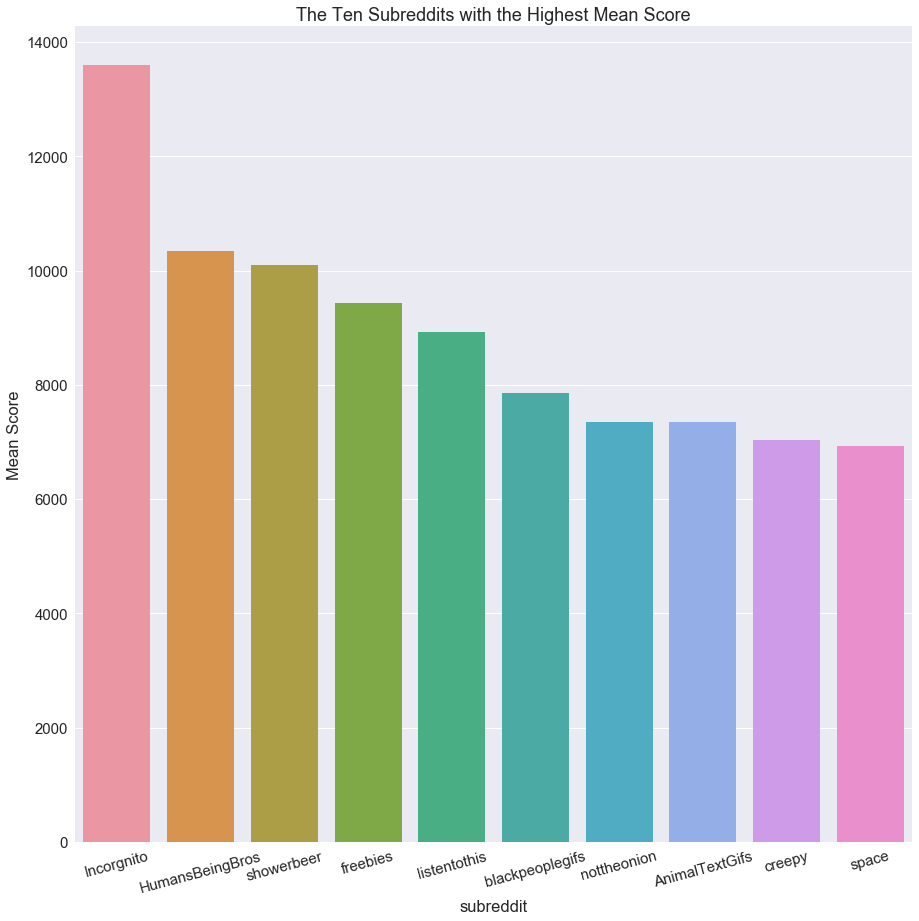

In [282]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)

scmeanorder = (dataunique.groupby('subreddit')['score'].apply(np.mean).sort_values(ascending = False)[:10].index)

sns.barplot(x='subreddit', y='score', data=dataunique, order=scmeanorder, ci=0)
plt.xticks(rotation=15)
plt.title('The Ten Subreddits with the Highest Mean Score')
plt.ylabel('Mean Score')

## Median Score for Top Ten Subreddits

Text(0,0.5,'Median Score')

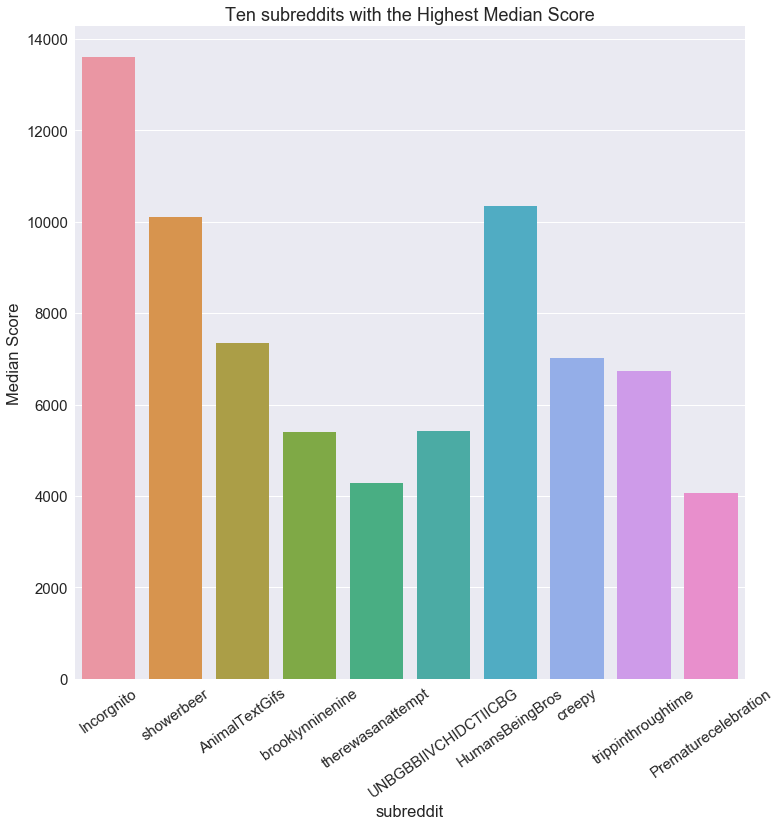

In [298]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

scmedorder = (dataunique.groupby('subreddit')['score'].apply(np.median).sort_values(ascending = False)[:10].index)

sns.barplot(x='subreddit', y='score', data=dataunique, order=scmedorder, ci=0)
plt.xticks(rotation=35)
plt.title('Ten subreddits with the Highest Median Score')
plt.ylabel('Median Score')

## Ten Subreddits with the Highest Mean Comment Count

Text(0,0.5,'Mean Number of Comments')

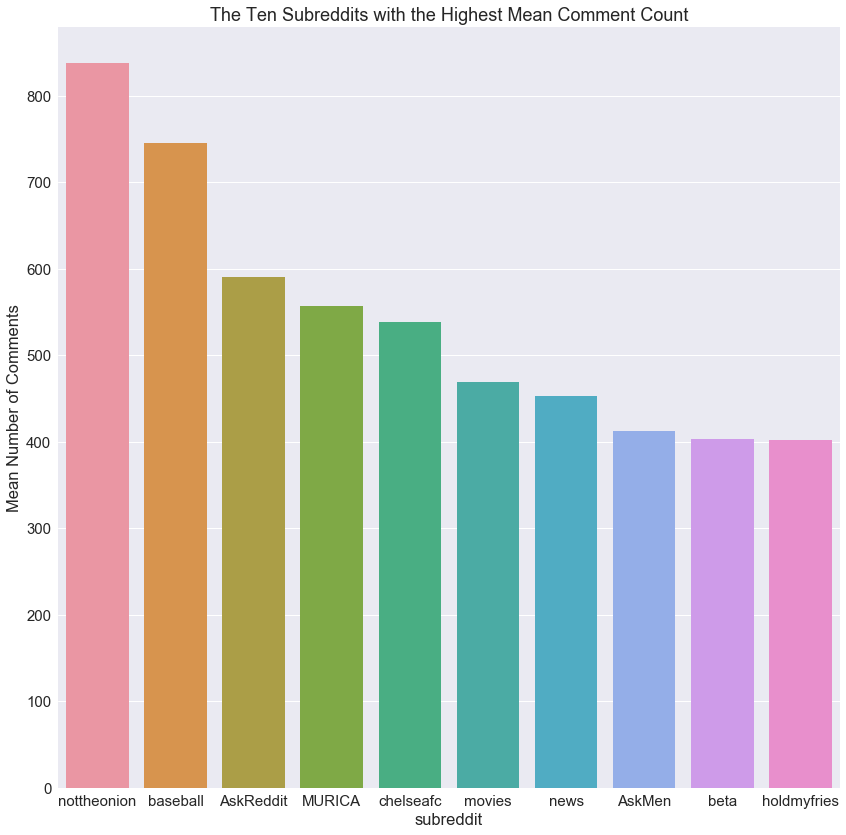

In [299]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 14)

order = (dataunique.groupby('subreddit')['comments'].apply(np.mean).sort_values(ascending = False)[:10].index)

sns.barplot(x='subreddit', y='comments', data=dataunique, order=order, ci=0)
plt.xticks(rotation=0)
plt.title('The Ten Subreddits with the Highest Mean Comment Count')
plt.ylabel("Mean Number of Comments")

## Ten subreddits with the Highest Median Comment Counts

Text(0,0.5,'Median Score')

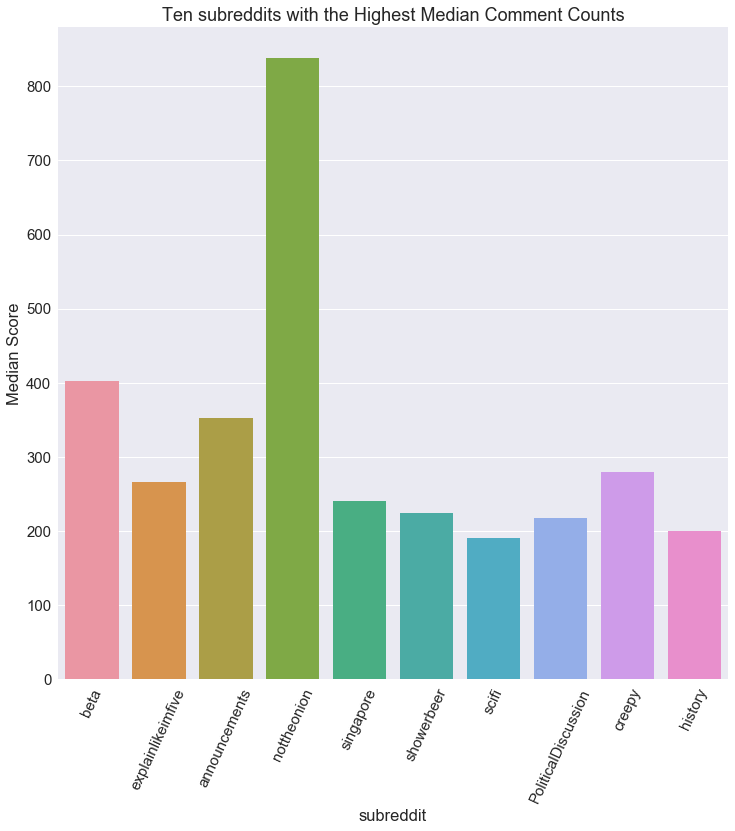

In [322]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

order = (dataunique.groupby('subreddit')['comments'].apply(np.median).sort_values(ascending = False)[:10].index)

sns.barplot(x='subreddit', y='comments', data=dataunique, order=order, ci=0)
plt.xticks(rotation=65)
plt.title('Ten subreddits with the Highest Median Comment Counts')
plt.ylabel('Median Score')

## Highest Mean Comment Count by Posting Hour (Times are in UTC)

Text(0.5,0,'Post Time (UTC)')

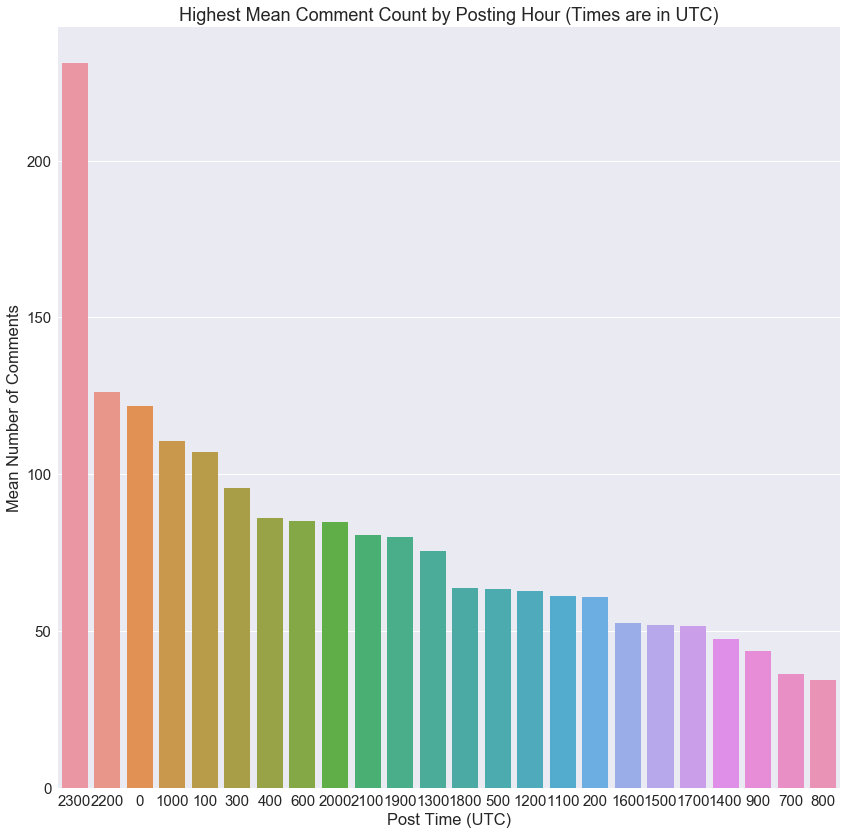

In [292]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 14)

order = (dataunique.groupby('post_time_hours')['comments'].apply(np.mean).sort_values(ascending = False)[:30].index)
sns.barplot(x='post_time_hours', y='comments', data=dataunique, order=order, ci=0)
plt.title('Highest Mean Comment Count by Posting Hour (Times are in UTC)')
plt.ylabel('Mean Number of Comments')
plt.xlabel('Post Time (UTC)')

Text(0.5,0,'Post Time (UTC)')

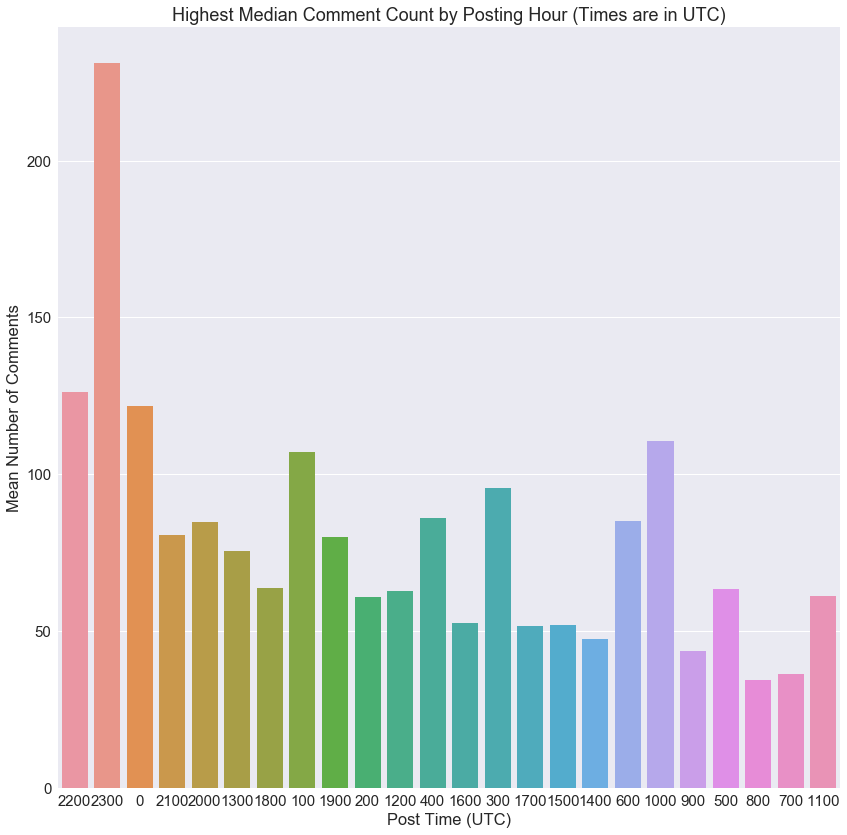

In [290]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 14)

order = (dataunique.groupby('post_time_hours')['comments'].apply(np.median).sort_values(ascending = False)[:30].index)
sns.barplot(x='post_time_hours', y='comments', data=dataunique, order=order, ci=0)
plt.title('Highest Median Comment Count by Posting Hour (Times are in UTC)')
plt.ylabel('Mean Number of Comments')
plt.xlabel('Post Time (UTC)')

## Mean Number of Comments by Day of the Week

Text(0.5,0,'Day of the Week')

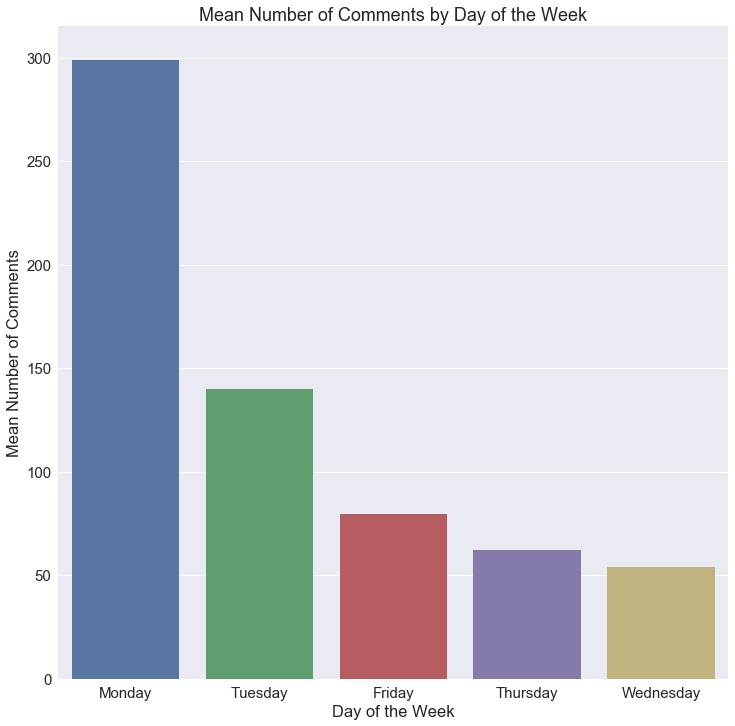

In [276]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

order = (dataunique.groupby('post_day_of_week')['comments'].apply(np.mean).sort_values(ascending = False)[:30].index)
sns.barplot(x='post_day_of_week', y='comments', data=dataunique, order=order, ci=0)
plt.title('Mean Number of Comments by Day of the Week')
plt.ylabel('Mean Number of Comments')
plt.xlabel('Day of the Week')

#Definitely somewhat misleading as I only really started scraping on Monday evening.

## Median Comment Count by Day of Week

Text(0.5,0,'Day of the Week')

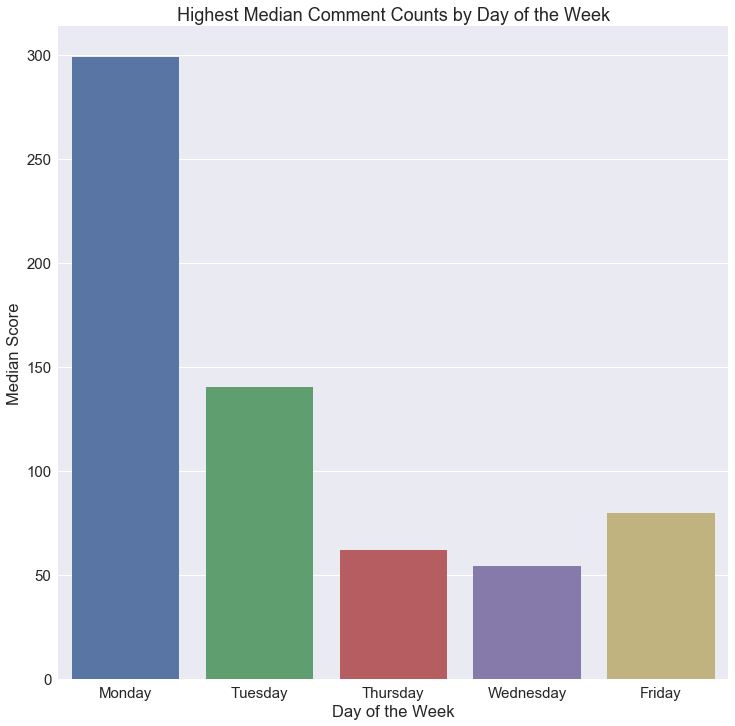

In [293]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

order = (dataunique.groupby('post_day_of_week')['comments'].apply(np.median).sort_values(ascending = False)[:10].index)

sns.barplot(x='post_day_of_week', y='comments', data=dataunique, order=order, ci=0)
# plt.xticks(rotation=35)
plt.title('Highest Median Comment Counts by Day of the Week')
plt.ylabel('Median Score')
plt.xlabel('Day of the Week')

## Mean Comment Score by Day of the Week

Text(0.5,0,'Day of the Week')

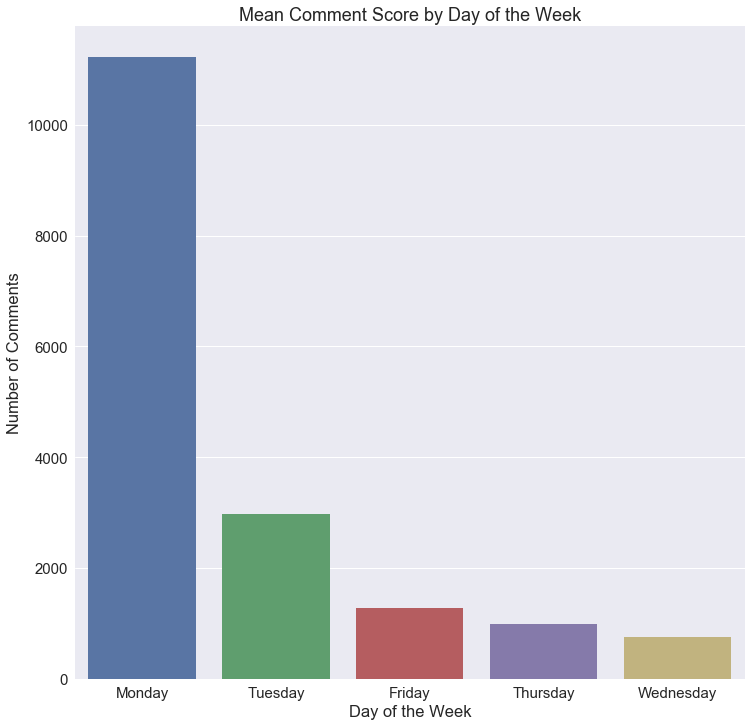

In [278]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

order = (dataunique.groupby('post_day_of_week')['score'].apply(np.mean).sort_values(ascending = False)[:30].index)
sns.barplot(x='post_day_of_week', y='score', data=dataunique, order=order, ci=0)
plt.title('Mean Comment Score by Day of the Week')
plt.ylabel('Number of Comments')
plt.xlabel('Day of the Week')

#Definitely somewhat misleading as I only really started scraping on Monday evening.

## Median Comment Score by Day of Week

Text(0,0.5,'Median Score')

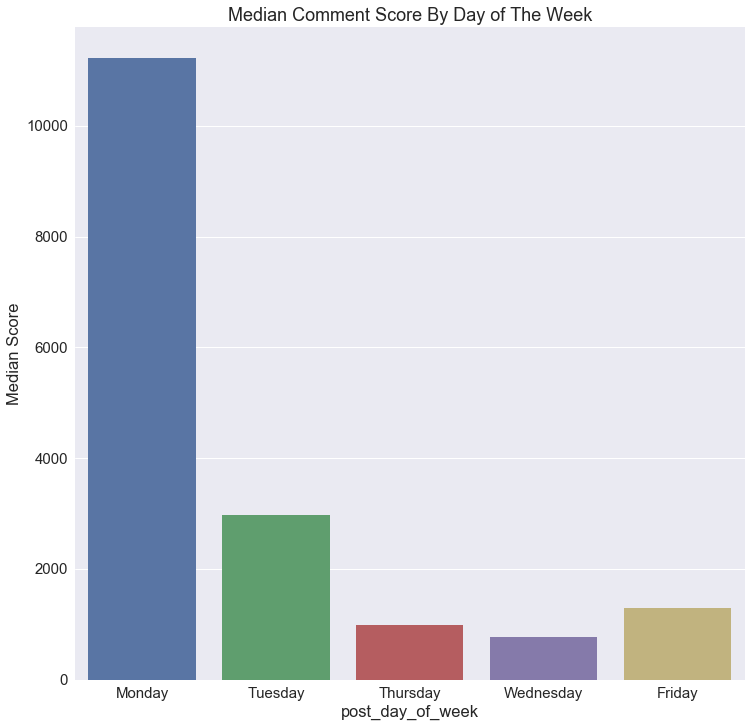

In [289]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

order = (dataunique.groupby('post_day_of_week')['score'].apply(np.median).sort_values(ascending = False)[:10].index)

sns.barplot(x='post_day_of_week', y='score', data=dataunique, order=order, ci=0)
# plt.xticks(rotation=35)
plt.title('Median Comment Score By Day of The Week')
plt.ylabel('Median Score')

# Modeling whether which percentile Post Number of Comments falls into is a function of the Subreddit

## Against Median Value

In [53]:
from sklearn.model_selection import train_test_split

datauniquenum1 = pd.get_dummies(datauniquenum1)

medX_train, medX_test, medy_train, medy_test = train_test_split(datauniquenum1.iloc[:,13:], datauniquenum1['Comments_Median'], random_state=0)

# NOTE: datauniquenum1[:,13:] represents the dummified subreddits

### Random Forest

In [54]:
from sklearn import preprocessing
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold

c = RandomForestClassifier(max_features=1)
d = cross_val_score(c, medX_train, medy_train, cv=3, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(medX_train, medy_train)
print("Random Forest Accuracy: %0.3f" % c.score(medX_test, medy_test))

Random Forest (Training) Score:	0.602 ± 0.026
Random Forest Accuracy: 0.607


### Decision Tree

In [215]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

c = DecisionTreeClassifier(max_depth=30)
d = cross_val_score(c, medX_train, medy_train, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(medX_train, medy_train)
print("Random Forest Accuracy: %0.3f" % c.score(medX_test, medy_test))

Random Forest (Training) Score:	0.606 ± 0.01
Random Forest Accuracy: 0.607


### Logistic Regression

In [209]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

datauniquenum1 = pd.get_dummies(datauniquenum1)
X_train, X_test, y_train, y_test = train_test_split(datauniquenum1.iloc[:,13:], datauniquenum1['Comments_25th_percentile'], test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
 
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)
print(classification_report(y_test,y_pred))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

[[  61  504]
 [  46 1726]]
             precision    recall  f1-score   support

          0       0.57      0.11      0.18       565
          1       0.77      0.97      0.86      1772

avg / total       0.72      0.76      0.70      2337

Accuracy of logistic regression classifier on test set: 0.76


## Against 25th Percentile

In [55]:
from sklearn.model_selection import train_test_split

datauniquenum1 = pd.get_dummies(datauniquenum1)

_25X_train, _25X_test, _25y_train, _25y_test = train_test_split(datauniquenum1.iloc[:,13:], datauniquenum1['Comments_25th_percentile'], test_size=0.3, random_state=0)

### Random Forest

In [60]:
from sklearn import preprocessing
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold

c = RandomForestClassifier(max_depth=10)
d = cross_val_score(c, _25X_train, _25y_train, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(_25X_train, _25y_train)
print("Random Forest Accuracy: %0.3f" % c.score(_25X_test, _25y_test))

Random Forest (Training) Score:	0.754 ± 0.001
Random Forest Accuracy: 0.758


### Decision Tree

In [214]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

c = DecisionTreeClassifier(max_depth=30)
d = cross_val_score(c, _25X_train, _25y_train, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(_25X_train, _25y_train)
print("Random Forest Accuracy: %0.3f" % c.score(_25X_test, _25y_test))

Random Forest (Training) Score:	0.761 ± 0.005
Random Forest Accuracy: 0.760


### Logistic Regression

In [208]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

datauniquenum1 = pd.get_dummies(datauniquenum1)
X_train, X_test, y_train, y_test = train_test_split(datauniquenum1.iloc[:,13:], datauniquenum1['Comments_25th_percentile'], test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
 
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)
print(classification_report(y_test,y_pred))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

[[  61  504]
 [  46 1726]]
             precision    recall  f1-score   support

          0       0.57      0.11      0.18       565
          1       0.77      0.97      0.86      1772

avg / total       0.72      0.76      0.70      2337

Accuracy of logistic regression classifier on test set: 0.76


## Against 75th Percentile

In [66]:
from sklearn.model_selection import train_test_split
_75X_train, _75X_test, _75y_train, _75y_test = train_test_split(datauniquenum1.iloc[:,13:], dataunique['Comments_75th_percentile'], test_size=0.3, random_state=0)

### Random Forest

In [67]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

c = RandomForestClassifier(max_depth=3)
d = cross_val_score(c, _75X_train, _75y_train, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(_75X_train, _75y_train)
print("Random Forest Accuracy: %0.3f" % c.score(_75X_test, _75y_test))

Random Forest (Training) Score:	0.744 ± 0.0
Random Forest Accuracy: 0.745


### Decision Tree

In [213]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

c = DecisionTreeClassifier(max_depth=30)
d = cross_val_score(c, _75X_train, _75y_train, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(_75X_train, _75y_train)
print("Random Forest Accuracy: %0.3f" % c.score(_75X_test, _75y_test))

Random Forest (Training) Score:	0.755 ± 0.005
Random Forest Accuracy: 0.752


### Logistic Regression

In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

datauniquenum1 = pd.get_dummies(datauniquenum1)
X_train, X_test, y_train, y_test = train_test_split(datauniquenum1.iloc[:,13:], datauniquenum1['Comments_75th_percentile'], test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
 
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)
print(classification_report(y_test,y_pred))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

[[1650   92]
 [ 459  136]]
             precision    recall  f1-score   support

          0       0.78      0.95      0.86      1742
          1       0.60      0.23      0.33       595

avg / total       0.74      0.76      0.72      2337

Accuracy of logistic regression classifier on test set: 0.76


## Against 95th Percentile

In [70]:
from sklearn.model_selection import train_test_split
_95X_train, _95X_test, _95y_train, _95y_test = train_test_split(datauniquenum1.iloc[:,13:], dataunique['Comments_95th_percentile'], test_size=0.3, random_state=0)

### Random Forest

In [71]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

c = RandomForestClassifier(max_depth=3)
d = cross_val_score(c, _95X_train, _95y_train, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(_95X_train, _95y_train)
print("Random Forest Accuracy: %0.3f" % c.score(_95X_test, _95y_test))

Random Forest (Training) Score:	0.948 ± 0.0
Random Forest Accuracy: 0.953


### Decision Tree

In [212]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

c = DecisionTreeClassifier(max_depth=30)
d = cross_val_score(c, _95X_train, _95y_train, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(_95X_train, _95y_train)
print("Random Forest Accuracy: %0.3f" % c.score(_95X_test, _95y_test))

Random Forest (Training) Score:	0.944 ± 0.002
Random Forest Accuracy: 0.947


### Logistic Regression

In [234]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

datauniquenum1 = pd.get_dummies(datauniquenum1)
X_train, X_test, y_train, y_test = train_test_split(datauniquenum1.iloc[:,13:], datauniquenum1['Comments_95th_percentile'], test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
 
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)
print(classification_report(y_test,y_pred))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

[[2226    0]
 [ 111    0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98      2226
          1       0.00      0.00      0.00       111

avg / total       0.91      0.95      0.93      2337

Accuracy of logistic regression classifier on test set: 0.95


/Users/skiparay/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Modeling whether which percentile Post Score falls into is a function of Subreddit

## Against Median Value

In [72]:
from sklearn.model_selection import train_test_split
scX_train, scX_test, scy_train, scy_test = train_test_split(datauniquenum1.iloc[:,13:], datauniquenum1['Score_Median'], test_size=0.3, random_state=0)

### Random Forest

In [73]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

c = RandomForestClassifier(max_depth=3)
d = cross_val_score(c, scX_train, scy_train, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(scX_train, scy_train)
print("Random Forest Accuracy: %0.3f" % c.score(scX_test, scy_test))

Random Forest (Training) Score:	0.601 ± 0.015
Random Forest Accuracy: 0.627


### Decision Tree

In [216]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation im port cross_val_score

c = DecisionTreeClassifier(max_depth=30)
d = cross_val_score(c, scX_train, scy_train, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(scX_train, scy_train)
print("Random Forest Accuracy: %0.3f" % c.score(_95X_test, _95y_test))

Random Forest (Training) Score:	0.61 ± 0.012
Random Forest Accuracy: 0.753


### Logistic Regression

In [205]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

datauniquenum1 = pd.get_dummies(datauniquenum1)
X_train, X_test, y_train, y_test = train_test_split(datauniquenum1.iloc[:,13:], datauniquenum1['Score_75th_percentile'], test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
 
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)
print(classification_report(y_test,y_pred))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

[[1693   81]
 [ 417  146]]
             precision    recall  f1-score   support

          0       0.80      0.95      0.87      1774
          1       0.64      0.26      0.37       563

avg / total       0.76      0.79      0.75      2337

Accuracy of logistic regression classifier on test set: 0.79


## Against 25th Percentile

In [75]:
from sklearn.model_selection import train_test_split
_25scX_train, _25scX_test, _25scy_train, _25scy_test = train_test_split(datauniquenum1.iloc[:,13:], datauniquenum1['Score_25th_percentile'], test_size=0.3, random_state=0)

### Random Forest

In [76]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

c = RandomForestClassifier(max_depth=3)
d = cross_val_score(c, _25scX_train, _25scy_train, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(_25scX_train, _25scy_train)
print("Random Forest Accuracy: %0.3f" % c.score(_25scX_test, _25scy_test))

Random Forest (Training) Score:	0.751 ± 0.0
Random Forest Accuracy: 0.748


### Decision Tree

In [222]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

c = DecisionTreeClassifier(max_depth=30)
d = cross_val_score(c, _25scX_train, _25scy_train, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(_25scX_train, _25scy_train)
print("Random Forest Accuracy: %0.3f" % c.score(_25scX_test, _25scy_test))

Random Forest (Training) Score:	0.748 ± 0.004
Random Forest Accuracy: 0.748


### Logistic Regression

In [204]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

datauniquenum1 = pd.get_dummies(datauniquenum1)
X_train, X_test, y_train, y_test = train_test_split(datauniquenum1.iloc[:,13:], datauniquenum1['Score_25th_percentile'], test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
 
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)
print(classification_report(y_test,y_pred))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

[[  60  528]
 [  52 1697]]
             precision    recall  f1-score   support

          0       0.54      0.10      0.17       588
          1       0.76      0.97      0.85      1749

avg / total       0.71      0.75      0.68      2337

Accuracy of logistic regression classifier on test set: 0.75


## Against 75th Percentile

In [78]:
from sklearn.model_selection import train_test_split
_75scX_train, _75scX_test, _75scy_train, _75scy_test = train_test_split(datauniquenum1.iloc[:,13:], datauniquenum1['Score_75th_percentile'], test_size=0.3, random_state=0)

### Random Forest

In [79]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

c = RandomForestClassifier(max_depth=3)
d = cross_val_score(c, _75scX_train, _75scy_train, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(_75scX_train, _75scy_train)
print("Random Forest Accuracy: %0.3f" % c.score(_75scX_test, _75scy_test))

Random Forest (Training) Score:	0.745 ± 0.0
Random Forest Accuracy: 0.759


### Decision Tree

In [218]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

c = DecisionTreeClassifier(max_depth=30)
d = cross_val_score(c, _75scX_train, _75scy_train, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(_75scX_train, _75scy_train)
print("Random Forest Accuracy: %0.3f" % c.score(_75scX_test, _75scy_test))

Random Forest (Training) Score:	0.752 ± 0.002
Random Forest Accuracy: 0.764


### Logistic Regression

In [202]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

datauniquenum1 = pd.get_dummies(datauniquenum1)
X_train, X_test, y_train, y_test = train_test_split(datauniquenum1.iloc[:,13:], datauniquenum1['Score_75th_percentile'], test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
 
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)
print(classification_report(y_test,y_pred))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

[[1693   81]
 [ 417  146]]
             precision    recall  f1-score   support

          0       0.80      0.95      0.87      1774
          1       0.64      0.26      0.37       563

avg / total       0.76      0.79      0.75      2337

Accuracy of logistic regression classifier on test set: 0.79


## Against 95th Percentile

In [80]:
from sklearn.model_selection import train_test_split
_95scX_train, _95scX_test, _95scy_train, _95scy_test = train_test_split(datauniquenum1.iloc[:,13:], datauniquenum1['Score_95th_percentile'], test_size=0.3, random_state=0)

### Random Forest

In [81]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

c = RandomForestClassifier(max_depth=3)
d = cross_val_score(c, _95scX_train, _95scy_train, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(_95scX_train, _95scy_train)
print("Random Forest Accuracy: %0.3f" % c.score(_95scX_test, _95scy_test))

Random Forest (Training) Score:	0.949 ± 0.0
Random Forest Accuracy: 0.952


### Decision Tree

In [221]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

c = DecisionTreeClassifier(max_depth=3)
d = cross_val_score(c, _95scX_train, _95scy_train, cv=3, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(_95scX_train, _95scy_train)
print("Random Forest Accuracy: %0.3f" % c.score(_95scX_test, _95scy_test))

/Users/skiparay/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


Random Forest (Training) Score:	0.014 ± 0.004
Random Forest Accuracy: 0.012


### Logistic Regression

In [201]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

datauniquenum1 = pd.get_dummies(datauniquenum1)
X_train, X_test, y_train, y_test = train_test_split(datauniquenum1.iloc[:,13:], datauniquenum1['Score_95th_percentile'], test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
 
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)
print(classification_report(y_test,y_pred))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

[[2224    0]
 [ 113    0]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.98      2224
          1       0.00      0.00      0.00       113

avg / total       0.91      0.95      0.93      2337

Accuracy of logistic regression classifier on test set: 0.95


/Users/skiparay/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# All together now (Comments)

In [235]:
datauniquenum1.head()

,comments,score,post_time_hours,rank,crossposts,Comments_25th_percentile,Comments_Median,Comments_75th_percentile,Comments_95th_percentile,Score_25th_percentile,...,subreddit_yourmomshousepodcast,subreddit_youseeingthisshit,subreddit_youtube,subreddit_youtubehaiku,subreddit_zelda,subreddit_zuckmemes,post_day_of_week_Monday,post_day_of_week_Thursday,post_day_of_week_Tuesday,post_day_of_week_Wednesday
0,5419,15315,1900,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,0
1,811,77648,1800,2,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,0
2,62,8202,1800,3,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
3,678,21656,1700,4,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,0
4,563,12019,1700,5,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,0


In [243]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

datauniquenum1 = pd.get_dummies(datauniquenum1)
X_train, X_test, y_train, y_test = train_test_split(datauniquenum1[['post_time_hours','crossposts', 'score']], datauniquenum1['comments'], test_size=0.3, random_state=0)

classifier = LogisticRegression()
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
 
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)
print(classification_report(y_test,y_pred))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

[[108  14   2 ...,   0   0   0]
 [ 88  29   3 ...,   0   0   0]
 [ 41  32   1 ...,   0   0   0]
 ..., 
 [  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]]
             precision    recall  f1-score   support

          0       0.22      0.81      0.34       133
          1       0.08      0.20      0.11       145
          2       0.02      0.01      0.01        95
          3       0.05      0.21      0.08        90
          4       0.00      0.00      0.00       102
          5       0.04      0.18      0.07        87
          6       0.00      0.00      0.00        97
          7       0.00      0.00      0.00        75
          8       0.03      0.09      0.05        70
          9       0.02      0.03      0.03        62
         10       0.02      0.01      0.02        71
         11       0.00      0.00      0.00        53
         12       0.00      0.00      0.00        50
         13       0.00      0.00      0.00        38
    

/Users/skiparay/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/skiparay/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Count Vectorizing the Post Titles

In [156]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from nltk.corpus import stopwords



cvec = CountVectorizer(stop_words='english', max_features=1000)
titledata = cvec.fit_transform(dataunique['title'])

#Applying a limit here to make sure I don't get non-english characters

In [157]:
titleframe = pd.DataFrame(titledata.todense(), columns = cvec.get_feature_names())

In [143]:
dataunique.shape

(8368, 21)

In [164]:
titleframe.nunique().sort_values(ascending=False)[:10]

11          4
apple       4
iphone      4
come        4
movie       4
world       4
series      4
guys        4
maybe       4
favorite    4
dtype: int64

In [145]:
dataandtitle = dataunique.merge(titleframe, left_on=dataunique['Score_95th_percentile'], right_index=True)

In [ ]:
dataandtitle.iloc[:,21:] #Just for my own personal info.

# Random Forest on New Dataframe

In [146]:
from sklearn.model_selection import train_test_split
dataandtitleX_train, dataandtitleX_test, dataandtitley_train, dataandtitley_test = train_test_split(dataandtitle.iloc[:,21:], dataandtitle['score'], test_size=0.3, random_state=0)

In [147]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

c = RandomForestClassifier(max_depth=5)
d = cross_val_score(c, dataandtitleX_train, dataandtitley_train, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest (Training)", d.mean().round(3), d.std().round(3)))
c.fit(dataandtitleX_train, dataandtitley_train)
print("Random Forest Accuracy: %0.3f" % c.score(dataandtitleX_test, dataandtitley_test))

#Wow.  Thats...really bad.  Like REALLY bad.

/Users/skiparay/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


Random Forest (Training) Score:	0.01 ± 0.003
Random Forest Accuracy: 0.009


# Executive Summary

     Predictions made against the median of the data gave a slightly better than coin flip (~60%) chance that the subreddit is a good indicator of post success. However, if post falls within the range of 25th or 75th percentile, model accuracy imnproves to around 75%. If the post is in the 95th percentile of score and comment count, the subreddit is an extremely good indicator of post success.
    
    Post score and comment count appear to be heavily affected by time of day/day of week.  Posts made on Mondays, at or around 2300 UTC (1900 EST) saw the highest score and comment count. No model correlation was proved, however.
    
    Title words did not appear to have a substantial effect on post score/comment count.
    
    Analysis of reddit is extremely difficult due to the fluid nature of the site.  High ranking posts may only remain on the hot page for a limited amount of time before disappearing off the front page.  Furthermore, post score and the comment count are not always good predictors of one another.  Moderation rules differ from subreddit to subreddit, meaning that comment counts can vary widely depending upon how often the moderator chooses to delete comments. Due to the way reddit's score system works, which, in turn, heavily affects a posts visibility on the front page, it is eminently possible that a group could engineer a script to rig upvotes.  When combined with a fanbase, posts would be more likely to appear on the front page, even if they are not actually getting views.  A recent example of this occured during the 2016 presedential election when it was alleged that members of r/thedonald had been engaging vote brigarding in order to artificially inflate the score value. Despite changes to the algorithim governing how 
    
    In short, were one of a less ethical bent, one could engineer a system whereby a post would gain maximum visibility without actually having had that many viewers/upvoters.
    